# Лабораторная работа 2

### Входные данные

In [149]:
N = 6
cols = ['height', 'mass', 'income', 'iq', 'pages', 'age', 'bmi', 'work_exp', 'friends', 'test_time']
col1_name = cols[N % 5]

print("First col", col1_name)

col2_name = cols[N**2 % 5 + 5]

print("Second col", col2_name)

First col mass
Second col bmi


In [58]:
import pandas as pd
import numpy as np

df = pd.read_csv("students_simple.csv")
df.head()


,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [59]:
series1 = pd.to_numeric(df[col1_name], errors="coerce").dropna().astype(float)

data_mass = series1.values

print("Размер:", len(data_mass))
print("Первые 10 элементов:", data_mass[:10])

series2 = pd.to_numeric(df[col2_name], errors="coerce").dropna().astype(float)

data_bmi = series2.values

print("Размер:", len(data_bmi))
print("Первые 10 элементов:", data_bmi[:10])

Размер: 20
Первые 10 элементов: [45. 61. 56. 48. 54. 58. 51. 62. 70. 72.]
Размер: 20
Первые 10 элементов: [3.533 2.623 2.875 3.375 3.    2.828 3.255 2.726 2.429 2.361]


## Расчет корреляций

### Фехнера



In [151]:
mean_mass = np.mean(data_mass)
print("Mean mass", mean_mass)

mean_bmi = np.mean(data_bmi)
print("Mean BMI", mean_bmi)

sign_mass = np.sign(data_mass - mean_mass)
sign_bmi = np.sign(data_bmi - mean_bmi)

same_sign = sign_mass == sign_bmi
diff_sign = sign_mass != sign_bmi

N_plus = np.sum(same_sign)
N_minus = np.sum(diff_sign)
n = len(data_mass)

K = (N_plus - N_minus) / n

print("Fechner correlation coefficient:", K)

Mean mass 67.45
Mean BMI 2.61335
Fechner correlation coefficient: -0.9


Вывод: коэффициент Фехнера будет отрицательный и близок к -1, что указывает на сильную обратную зависимость, т.е. высокая масса соответствует низкому BMI и наоборот — строгая обратная зависимость.

### Пирсона + доверительный интервал

In [152]:
import math


cov = sum((data_mass[i] - mean_mass) * (data_bmi[i] - mean_bmi) for i in range(n)) / (n - 1)
print("Covariation", cov)

Sx = math.sqrt(sum((data_mass[i] - mean_mass)**2 for i in range(n)) / (n - 1))
Sy = math.sqrt(sum((data_bmi[i] - mean_bmi)**2 for i in range(n)) / (n - 1))

print("Sx", Sx)
print("Sy", Sy)

# Коэф корреляции Пирсона
r = cov / (Sx * Sy)
print("r", r)

# T-stat (n - 2) степеней свободы
T = r * math.sqrt(n - 2) / math.sqrt(1 - r**2)
print(f"T = {T}, df = {n-2}")

Covariation -5.70663947368421
Sx 13.620707918846447
Sy 0.4361480042129591
r -0.9606094762709692
T = -14.665325033154902, df = 18


Вывод: связь статистически значимая

In [153]:
# доверительный интервал

alpha = 0.05
z_crit = 1.96
z = 0.5 * math.log((1 + r) / (1 - r))
se = 1 / math.sqrt(n - 3)
z_low = z - z_crit * se
z_high = z + z_crit * se
r_low = (math.exp(2 * z_low) - 1) / (math.exp(2 * z_low) + 1)
r_high = (math.exp(2 * z_high) - 1) / (math.exp(2 * z_high) + 1)


print(f"Trust interval [{r_low}, {r_high}]")

Trust interval [-0.9845911325076979, -0.9011626884112891]


Вывод: весь интервал отрицательный, не включает 0, что подтверждает значимую обратную связь

Узкий интервал значит, что оценка надёжная, разброс значений относительно корреляции небольшой

### Спирмена

In [154]:
def rank(data):
    sorted_data = sorted((val, i) for i, val in enumerate(data))
    ranks = [0]*len(data)
    for rank_num, (_, i) in enumerate(sorted_data, start=1):
        ranks[i] = rank_num
    return ranks

rank_x = rank(data_mass)
rank_y = rank(data_bmi)

d = [rank_x[i] - rank_y[i] for i in range(n)]
d_squared = [di**2 for di in d]

r_s = 1 - (6 * sum(d_squared)) / (n*(n**2 - 1))

print(f"Spearman correlation r_s = {r_s:.4f}")

Spearman correlation r_s = -0.9789


Если результат близок к -1, то сильная обратная монотонная зависимость:
- То есть чем больше масса, тем меньше BMI, практически строго по монотонной линии

### Кенделла

In [155]:
C = 0
D = 0

for i in range(n-1):
    for j in range(i+1, n):
        xi, xj = data_mass[i], data_mass[j]
        yi, yj = data_bmi[i], data_bmi[j]
        if (xi - xj)*(yi - yj) > 0:
            C += 1
        elif (xi - xj)*(yi - yj) < 0:
            D += 1

tau = (C - D) / (0.5 * n * (n-1))

print(f"Kendall tau = {tau:.4f}")

Kendall tau = -0.9316


τ < 0 говорит о обратной зависимости между массой и BMI: чем больше масса, тем меньше BMI в этом наборе данных.

Абсолютное значение τ близко к 1, то сильная корреляция

## Гистограммы

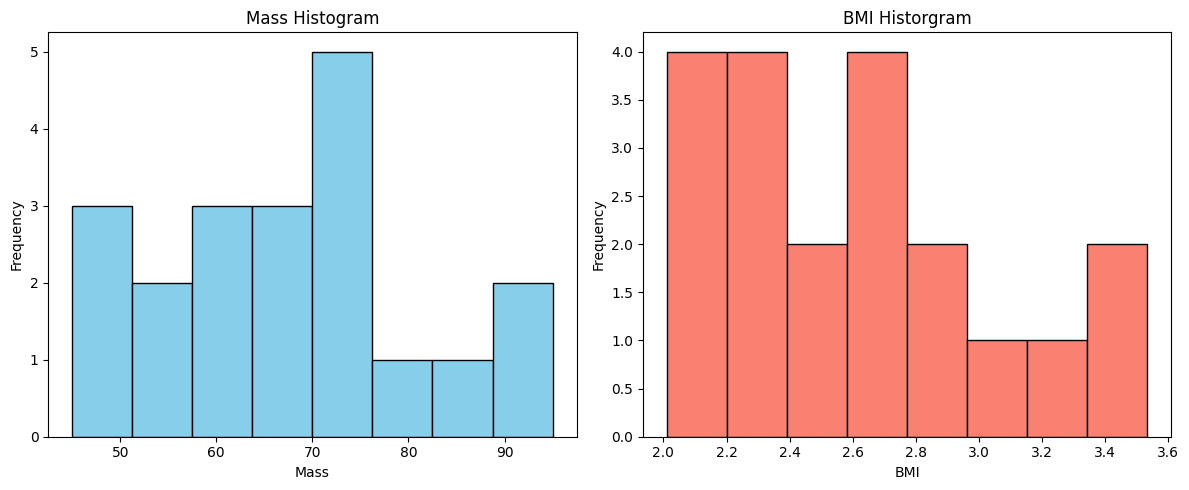

In [156]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(data_mass, bins=8, color='skyblue', edgecolor='black')
plt.title('Mass Histogram')
plt.xlabel('Mass')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(data_bmi, bins=8, color='salmon', edgecolor='black')
plt.title('BMI Historgram')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## График рассеяния

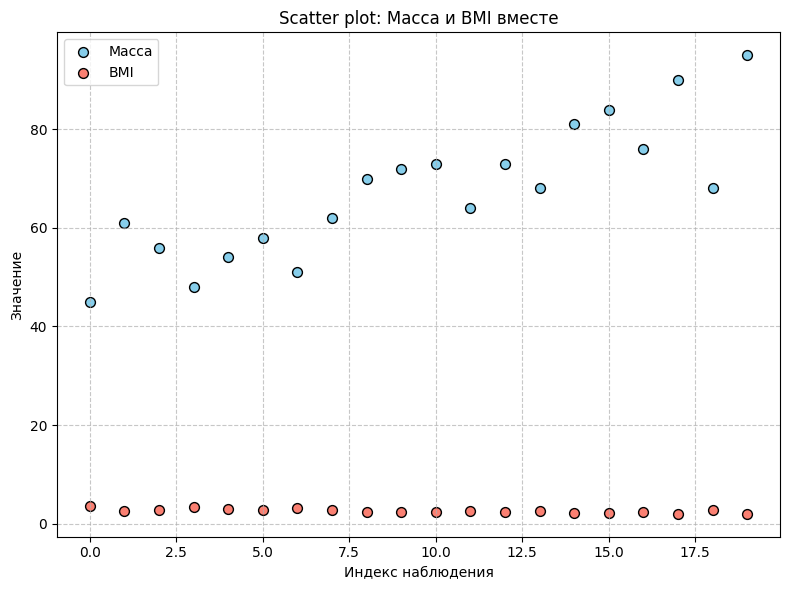

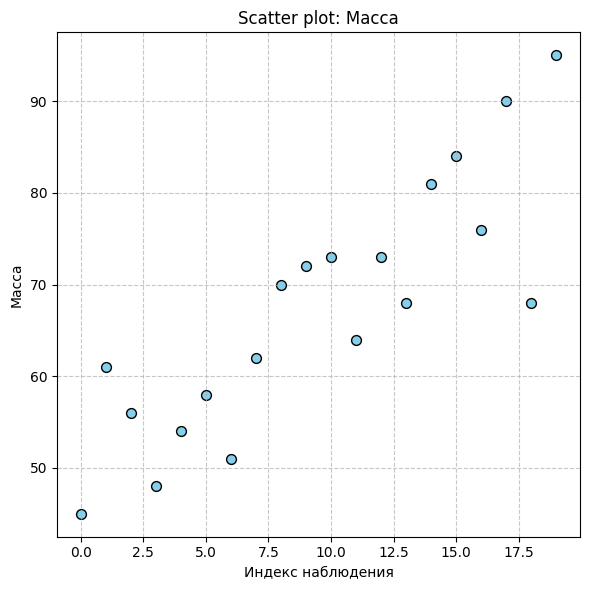

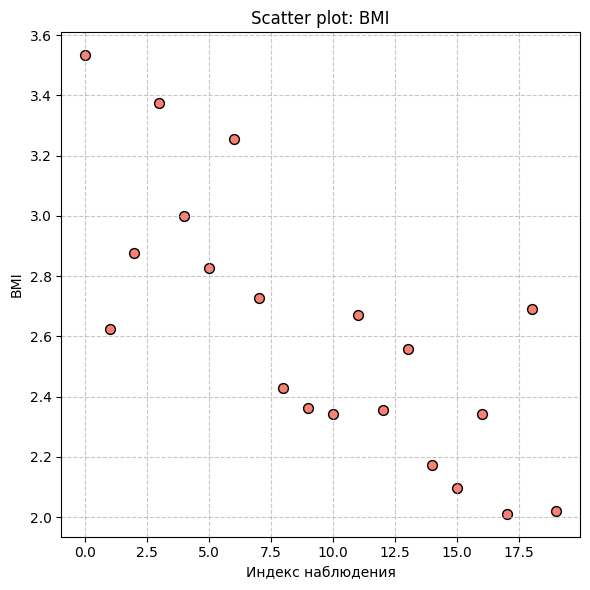

In [157]:
import numpy as np
import matplotlib.pyplot as plt

indices = np.arange(len(data_mass))

plt.figure(figsize=(8,6))
plt.scatter(indices, data_mass, color='skyblue', s=50, label='Масса', edgecolor='black')
plt.scatter(indices, data_bmi, color='salmon', s=50, label='BMI', edgecolor='black')

plt.title('Scatter plot: Масса и BMI вместе')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(indices, data_mass, color='skyblue', s=50, edgecolor='black')
plt.title('Scatter plot: Масса')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Масса')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(indices, data_bmi, color='salmon', s=50, edgecolor='black')
plt.title('Scatter plot: BMI')
plt.xlabel('Индекс наблюдения')
plt.ylabel('BMI')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Уравнения регрессии

### Линейная

$y=w_1 x + w_0$

Уравнение линейной регрессии:
y = -0.030759627796139173x + 4.6880868948495875


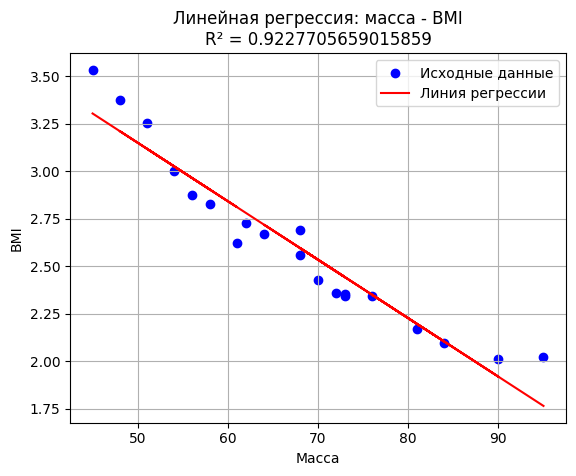

In [158]:
n = len(data_mass)

sum_mass = sum(data_mass)
sum_bmi = sum(data_bmi)
sum_x2 = sum([xi**2 for xi in data_mass])
sum_xy = sum([data_mass[i] * data_bmi[i] for i in range(n)])

w1 = (n * sum_xy - sum_mass * sum_bmi) / (n * sum_x2 - sum_mass**2)
w0 = (sum_bmi - w1 * sum_mass) / n

print("Уравнение линейной регрессии:")
print(f"y = {w1}x + {w0}")

y_pred = [w1 * x + w0 for x in data_mass]

y_mean = sum(data_bmi) / n
ss_res = sum((data_bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((data_bmi[i] - y_mean)**2 for i in range(n))
r2_linear = 1 - ss_res / ss_tot

linear_params = {'w1': w1, 'w0': w0, 'r2': r2_linear}

plt.scatter(data_mass, data_bmi, color='blue', label='Исходные данные')
plt.plot(data_mass, y_pred, color='red', label='Линия регрессии')

plt.title(f'Линейная регрессия: масса - BMI\nR² = {r2_linear}')
plt.xlabel('Масса')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()


In [159]:
n = len(data_mass)
k = 2

F_stat_linear = (r2_linear / (1 - r2_linear)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_linear:.4f}")
print(f"Коэффициент детерминации R² = {r2_linear}")

linear_params['F_stat'] = F_stat_linear

F-статистика = 215.0718
Коэффициент детерминации R² = 0.9227705659015859


### Квадратичная

$y = w_2 x^2 + w_1 x + w_0$



Уравнение квадратичной регрессии:
y = 0.0004932908121906034x² + -0.0989982134729462x + 6.959610443040478
Коэффициент детерминации R² = 0.9779302384431466


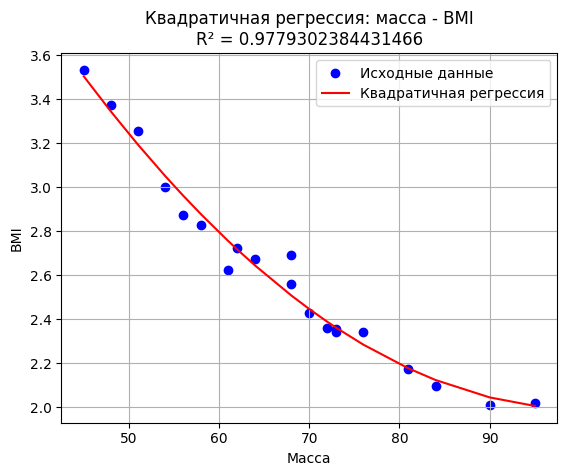

In [ ]:
n = len(data_mass)

sum_x = sum(data_mass)
sum_x2 = sum(x**2 for x in data_mass)
sum_x3 = sum(x**3 for x in data_mass)
sum_x4 = sum(x**4 for x in data_mass)
sum_y = sum(data_bmi)
sum_xy = sum(data_mass[i] * data_bmi[i] for i in range(n))
sum_x2y = sum((data_mass[i]**2) * data_bmi[i] for i in range(n))

A = [
    [sum_x4, sum_x3, sum_x2],
    [sum_x3, sum_x2, sum_x],
    [sum_x2, sum_x, n]
]
B = [sum_x2y, sum_xy, sum_y]

w2, w1, w0 = np.linalg.solve(A, B)

print("Уравнение квадратичной регрессии:")
print(f"y = {w2}x² + {w1}x + {w0}")

y_pred = [w2 * x**2 + w1 * x + w0 for x in data_mass]

y_mean = sum(data_bmi) / n
ss_res = sum((data_bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((data_bmi[i] - y_mean)**2 for i in range(n))
r2_quadratic = 1 - ss_res / ss_tot

quadratic_params = {'w2': w2, 'w1': w1, 'w0': w0, 'r2': r2_quadratic}

print(f"Коэффициент детерминации R² = {r2_quadratic}")

x_sorted = sorted(data_mass)
y_fit = [w2 * x**2 + w1 * x + w0 for x in x_sorted]

plt.scatter(data_mass, data_bmi, color='blue', label='Исходные данные')
plt.plot(x_sorted, y_fit, color='red', label='Квадратичная регрессия')
plt.title(f'Квадратичная регрессия: масса - BMI\nR² = {r2_quadratic}')
plt.xlabel('Масса')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
n = len(data_mass)
k = 3 

F_stat_quadratic = (r2_quadratic / (1 - r2_quadratic)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_quadratic:.4f}")
print(f"Коэффициент детерминации R² = {r2_quadratic}")


quadratic_params['F_stat'] = F_stat_quadratic

F-статистика = 376.6424
Коэффициент детерминации R² = 0.9779302384431466


### Гиперболическое

Уравнение гиперболической регрессии:
y = 135.2426760314924/x + 0.5275204317277001
Коэффициент детерминации R² = 0.979132744595704


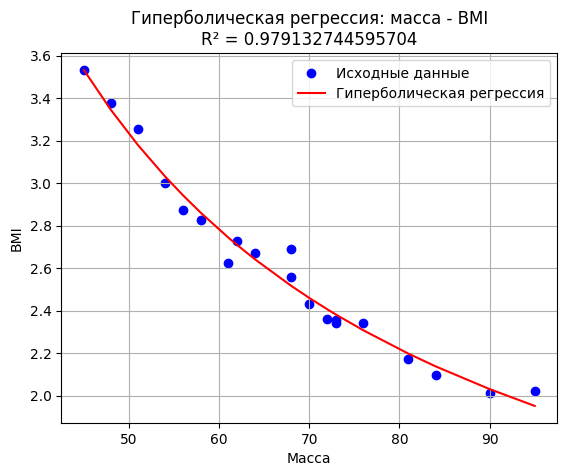

In [ ]:
n = len(data_mass)

z = [1/x for x in data_mass]

sum_z = sum(z)
sum_y = sum(data_bmi)
sum_z2 = sum(zi**2 for zi in z)
sum_zy = sum(z[i] * data_bmi[i] for i in range(n))

w1 = (n * sum_zy - sum_z * sum_y) / (n * sum_z2 - sum_z**2)
w0 = (sum_y - w1 * sum_z) / n

print("Уравнение гиперболической регрессии:")
print(f"y = {w1}/x + {w0}")

y_pred = [w1 / x + w0 for x in data_mass]

y_mean = sum(data_bmi) / n
ss_res = sum((data_bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((data_bmi[i] - y_mean)**2 for i in range(n))
r2_hyperbolic = 1 - ss_res / ss_tot

hyperbolic_params = {'w1': w1, 'w0': w0, 'r2': r2_hyperbolic}

print(f"Коэффициент детерминации R² = {r2_hyperbolic}")

x_sorted = sorted(data_mass)
y_fit = [w1 / x + w0 for x in x_sorted]

plt.scatter(data_mass, data_bmi, color='blue', label='Исходные данные')
plt.plot(x_sorted, y_fit, color='red', label='Гиперболическая регрессия')

plt.title(f'Гиперболическая регрессия: масса - BMI\nR² = {r2_hyperbolic}')
plt.xlabel('Масса')
plt.ylabel('BMI')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
n = len(data_mass)
k = 2

F_stat_hyperbolic = (r2_hyperbolic / (1 - r2_hyperbolic)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_hyperbolic:.4f}")
print(f"Коэффициент детерминации R² = {r2_hyperbolic}")

hyperbolic_params['F_stat'] = F_stat_hyperbolic

F-статистика = 844.5955
Коэффициент детерминации R² = 0.979132744595704


### Показательное

Уравнение показательной регрессии:
y = 5.685705158191554 * (0.9883536023507961)^x
R² = 0.9542387362820838
R² (для логарифмической модели) = 0.9536062617124696


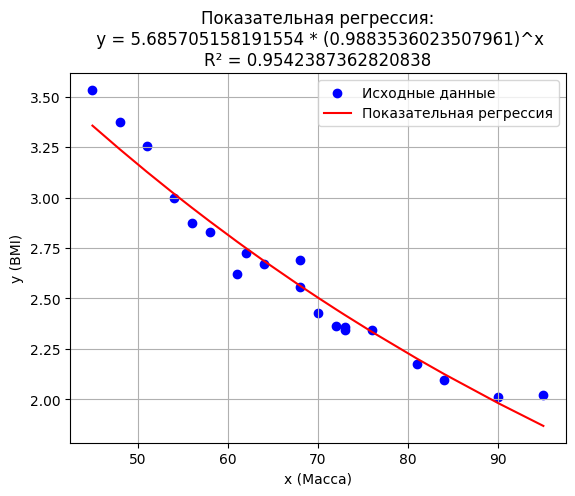

In [ ]:
import math
import matplotlib.pyplot as plt

n = len(data_mass)

lny = [math.log(v) for v in data_bmi]

sum_x = sum(data_mass)
sum_x2 = sum(xi**2 for xi in data_mass)
sum_lny = sum(lny)
sum_xlny = sum(data_mass[i]*lny[i] for i in range(n))

den = n * sum_x2 - sum_x**2
a1 = (n * sum_xlny - sum_x * sum_lny) / den
a0 = (sum_lny - a1 * sum_x) / n

w1 = math.exp(a1)
w0 = math.exp(a0)

print("Уравнение показательной регрессии:")
print(f"y = {w0} * ({w1})^x")

y_pred = [w0 * (w1 ** xi) for xi in data_mass]

y_mean = sum(data_bmi) / n
ss_res = sum((data_bmi[i] - y_pred[i])**2 for i in range(n))
ss_tot = sum((data_bmi[i] - y_mean)**2 for i in range(n))
r2_exponential = 1 - ss_res / ss_tot

exponential_params = {'w0': w0, 'w1': w1, 'r2': r2_exponential}

print(f"R² = {r2_exponential}")

lny_mean = sum(lny) / n
ss_res_log = sum((lny[i] - (a0 + a1 * data_mass[i]))**2 for i in range(n))
ss_tot_log = sum((lny[i] - lny_mean)**2 for i in range(n))
r2_log = 1 - ss_res_log / ss_tot_log
print(f"R² (для логарифмической модели) = {r2_log}")

x_sorted = sorted(data_mass)
y_fit = [w0 * (w1 ** xi) for xi in x_sorted]

plt.scatter(data_mass, data_bmi, label='Исходные данные', color='blue')
plt.plot(x_sorted, y_fit, label='Показательная регрессия', color='red')
plt.title(f'Показательная регрессия:\n y = {w0} * ({w1})^x\nR² = {r2_exponential}')
plt.xlabel('x (Масса)')
plt.ylabel('y (BMI)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
n = len(data_mass)
k = 2

F_stat_exponential = (r2_exponential / (1 - r2_exponential)) * ((n - k) / (k - 1))
print(f"F-статистика = {F_stat_exponential:.4f}")
print(f"Коэффициент детерминации R² = {r2_exponential}")

exponential_params['F_stat'] = F_stat_exponential

F-статистика = 375.3458
Коэффициент детерминации R² = 0.9542387362820838


## Проверка

## Проверка соответствия модели данным с помощью критерия Фишера

### Анализ качества уравнений регрессии

Из проведенных расчетов видно:
- **Наилучшее уравнение**: Гиперболическая регрессия (R² = 0.9791)
- **Наихудшее уравнение**: Линейная регрессия (R² = 0.9228)


In [168]:
n = len(data_mass)
alpha = 0.05

F_critical_values = {
    (1, 18): 4.41,
    (2, 17): 3.59
}

results = [
    {'name': 'Линейная', 'r2': linear_params['r2'], 'F_stat': linear_params['F_stat'], 'k': 2},
    {'name': 'Квадратичная', 'r2': quadratic_params['r2'], 'F_stat': quadratic_params['F_stat'], 'k': 3},
    {'name': 'Гиперболическая', 'r2': hyperbolic_params['r2'], 'F_stat': hyperbolic_params['F_stat'], 'k': 2},
    {'name': 'Показательная', 'r2': exponential_params['r2'], 'F_stat': exponential_params['F_stat'], 'k': 2}
]

for result in results:
    df1 = result['k'] - 1
    df2 = n - result['k']
    result['F_critical'] = F_critical_values.get((df1, df2), 4.0)
    result['significant'] = result['F_stat'] > result['F_critical']

print(f"{'Модель':<15} | {'R²':<6} | {'F':<6} | {'F_кр':<6} | {'Значима'}")
print("-"*55)


for res in results:
    print(f"{res['name']:<15} | "
          f"{res['r2']:<6.4f} | "
          f"{res['F_stat']:<6.2f} | "
          f"{res['F_critical']:<6.2f} | "
          f"{'Да' if res['significant'] else 'Нет'}")


print()

sorted_results = sorted(results, key=lambda x: x['r2'], reverse=True)
for i, res in enumerate(sorted_results, 1):
    print(f"{i}. {res['name']}: R² = {res['r2']:.4f}")



Модель          | R²     | F      | F_кр   | Значима
-------------------------------------------------------
Линейная        | 0.9228 | 215.07 | 4.41   | Да
Квадратичная    | 0.9779 | 376.64 | 3.59   | Да
Гиперболическая | 0.9791 | 844.60 | 4.41   | Да
Показательная   | 0.9542 | 375.35 | 4.41   | Да

1. Гиперболическая: R² = 0.9791
2. Квадратичная: R² = 0.9779
3. Показательная: R² = 0.9542
4. Линейная: R² = 0.9228
